In [78]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as pyp
from scipy.cluster.vq import vq, kmeans, whiten

In [6]:
def process_value(value):
    # Fill in this function if you're 
    # considering time values as well
    pass
        

In [52]:
def dataset_loader(participant):
    # Load the file 
    participant = "participant_" + str(participant)
    f = open("dataset/dataset_web/{}.csv".format(participant), "r+")
    
    # Read the names of the columns
    columns = f.readline()
    columns = columns.split(";")
    
    first_row = f.readline()
    first_row = first_row.split(";")
    first_row = first_row[5:] # Note: Remove this if time is included
    first_row = [float(num) for num in first_row]
    
    features = [np.array(first_row)]

    count = 500
    for row in f:
        row = row.split(";")
        row = row[5:]
        row = [float(num) for num in row]
        
        features.append(row)
        if not count:
            break
        count = count - 1
        
    return np.array(features)



In [63]:
def pca(x, dim):
    
    x_shape = np.shape(x)
    if len(x_shape) < 2:
        print("check the shape of X")
        return
    
#     print(x_shape)
    extract_dimension = lambda x, pos:[k[pos] for k in x]
    MUx = [np.average(extract_dimension(x, z)) for z in range(x_shape[1])]
#     print(MUx)
#     r  = np.array([1,2])
#     print(np.shape(r-MUx), np.shape(np.transpose(r-MUx)))
#     print(np.matmul([r-MUx], np.transpose([r-MUx])))
    Cx = np.zeros([x_shape[1], x_shape[1]])
#     matrices=[np.matmul(np.transpose([xi-MUx]), [xi-MUx]) for xi in x]
#     print(np.shape(matrices))
#     Cx = np.add(*matrices)# Covarience matrix
    
    for xi in x:
        Cx += np.matmul(np.transpose([xi-MUx]), [xi-MUx])
    
    eig_vals, eig_vectors = np.linalg.eig(Cx)
    eig_dict = dict(zip(eig_vals, eig_vectors))
    w=[]
    
    count = 0
    for val in sorted(eig_vals):
        w.append(eig_dict[val])
        count = count + 1
        if count == dim:
            break
    
    return np.matmul(x, np.transpose(w))
x = [[1,2,5,6,7],[2,4,1,3,5],[2,5,2,4,5]]
pca(np.array([np.array(xi) for xi in x]),3)


array([[ 7.39077306,  6.11825602,  2.12262043],
       [ 3.19824491,  3.70990538, -0.66083022],
       [ 3.99888204,  4.25567905,  0.29511961]])

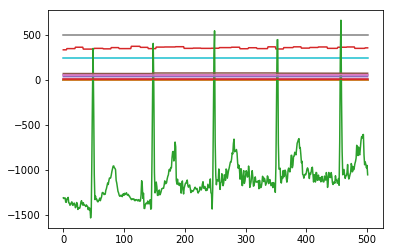

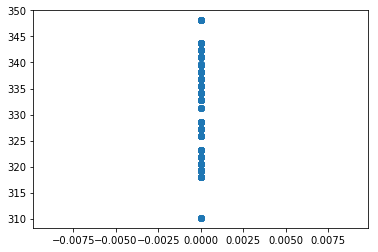

In [77]:
features = dataset_loader(1)
# print(np.shape(features))
pyp.plot(features)
pyp.show()
reduced_features = pca(features, 2)
x,y = reduced_features.T
pyp.scatter(x, y)
pyp.show()

In [82]:
def k_means(features, clusters):
    
    whitened = whiten(features)
    print(np.shape(whitened))
    classes, _ = kmeans(whitened, clusters)
    print(classes)
    
features = dataset_loader(1)
k_means(features, 10)
    

(502, 17)
[[ -7.36945441e+00   1.93320281e+02   3.56929395e-02   4.10998582e+01
    1.22509645e+14   2.56373321e+15   1.00000000e+01   4.97000000e+02
    3.13872137e+14   1.44665524e+14   0.00000000e+00   0.00000000e+00
   -3.86451247e+00   2.68835455e+01   2.98822754e+03   2.86882645e+01
    4.58813254e+01]]


/Users/shravan/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:147: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)
